In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
import torch

# 1. Загрузка данных
iris = load_iris()
X = iris.data  # Признаки (4 признака)
y = iris.target  # Метки (3 класса)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Создание DataLoader для удобства работы с данными
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [14]:
from torch import nn

class IrisClassifier(nn.Module):
    def __init__(self):
        super(IrisClassifier, self).__init__()
        self.l1 = nn.Sequential(
            nn.Linear(4, 16),  # Входной слой: 4 признака -> 16 нейронов
            nn.ReLU(),
        )
        self.l2 = nn.Sequential(
            nn.Linear(16, 16),
            nn.ReLU(),
        )
        self.l3 = nn.Sequential(
            nn.Linear(16, 3)
        )

    def forward(self, x):
        logits = self.l3(self.l2(self.l1(x)))
        return logits

In [15]:
from ogo import ExperimentDescription, generate_experiment, model_train_step, model_test

description = ExperimentDescription(
    model=IrisClassifier,
    loss=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer_params={"lr": 1e-3},
    dataset_train=train_dataset,
    dataset_test=test_dataset,
    batch_size=16,
    epochs=100,
    model_copies_epochs=1,
    model_copies_submodules=[["l1"], ["l2"], ["l3"]],
    model_reference_device="cuda",
    model_general_device="cuda",
    model_copies_devices=["cuda","cuda","cuda"],
    model_train_step=model_train_step,
    model_test=model_test
)

experiment = generate_experiment(description)

In [16]:
from ogo import experiment_train_reference

experiment_train_reference(experiment)
# experiment.model_reference.history

100%|██████████| 100/100 [00:01<00:00, 50.83it/s]


In [17]:
from ogo import experiment_train_general

experiment_train_general(experiment)
# experiment.model_general.history

100%|██████████| 100/100 [00:05<00:00, 19.36it/s]


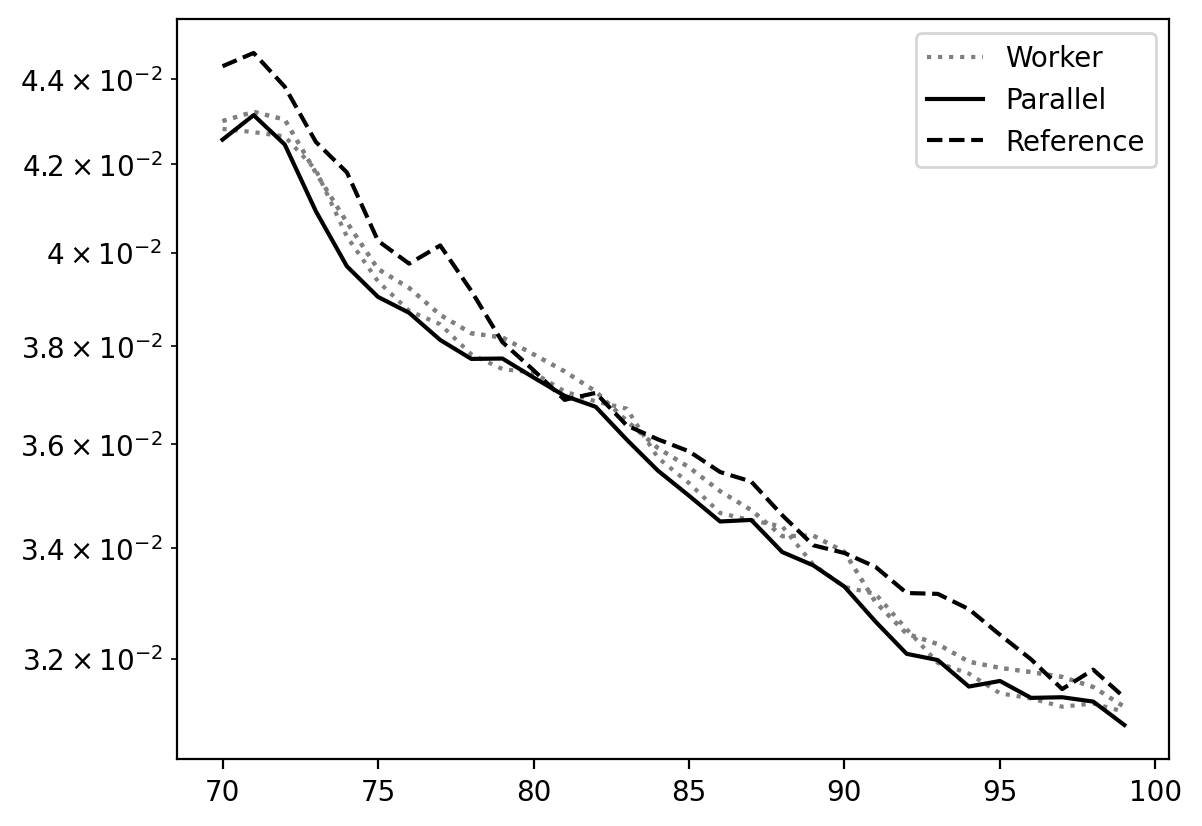

In [24]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

start = 70
stop = experiment.epochs
x = range(start, stop)
copy_step = 1
general_step = 1
reference_step = 1

# for m in experiment.model_copies:
#     plt.plot(x, [x["loss"] for x in m.history[start:stop:copy_step]], linestyle='dotted', color='gray')

plt.plot(x, [x["loss"] for x in experiment.model_copies[0].history[start:stop:copy_step]], linestyle='dotted', color='gray', label='Worker')

for m in experiment.model_copies[:-1]:
    plt.plot(x, [x["loss"] for x in m.history[start:stop:copy_step]], linestyle='dotted', color='gray')

plt.plot(x, [x["loss"] for x in experiment.model_general.history[start:stop:general_step]], label='Parallel', color='black', linestyle='solid')
plt.plot(x, [x["loss"] for x in experiment.model_reference.history[start:stop:reference_step]], label='Reference', color='black', linestyle='dashed')

plt.legend()
plt.yscale('log')
plt.show()

In [19]:
experiment.model_general.history[-1]

{'accuracy': 100.0, 'loss': 0.030853550881147385}